In [1]:
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import xarray as xr
import os
import matplotlib
import matplotlib.colors as colors

matplotlib.rcParams["figure.dpi"] = 50

In [2]:
from xhistogram.xarray import histogram

In [3]:
proc_path = "../data/processed/NOAA_OISST_means.nc"
if not(os.path.isfile(proc_path)):
    raw_path = "../data/raw_observational_products/www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/v2.1/access/avhrr"
    ds_raw = xr.open_mfdataset(f"{avhrr_path}/*/*.nc")
    ds_raw = ds_raw.sel(time=slice('1982', '2023')) # pick out only full years

    ds = xr.Dataset()
    for v in ['sst', 'ice']:
        ds[f'{v}_mean'] = ds_raw[v].mean('time')
        ds[f'{v}_1982-1991_mean'] = ds_raw[v].sel(time=slice('1982', '1991')).mean('time')
        ds[f'{v}_2014-2023_mean'] = ds_raw[v].sel(time=slice('2014', '2023')).mean('time')
        ds[f'{v}_seasonal_climatology'] = ds_raw[v].groupby('time.season').mean('time')
    ds.to_netcdf()
    ds.close()

ds = xr.open_dataset(proc_path)

In [4]:
ds_woce = xr.open_dataset("../data/raw_observational_products/WGHC/wghc_params.nc")

In [5]:
TS_hist = histogram(
    ds_woce.SALINITY,
    ds_woce.TEMP,
    bins=[np.arange(-0.05, 50.1, 0.1), np.arange(-3, 40.1, 0.2)],
    block_size=None
).compute()

In [6]:
TS_hist_hires = histogram(
    ds_woce.SALINITY,
    ds_woce.TEMP,
    bins=[np.arange(-0.05, 50.1, 0.01), np.arange(-3, 40.1, 0.02)],
    block_size=None
).compute()

In [7]:
import gsw

In [8]:
TS_hist["rho"] = gsw.rho_t_exact(TS_hist.SALINITY_bin, TS_hist.TEMP_bin, 0.)
TS_hist_hires["rho"] = gsw.rho_t_exact(TS_hist_hires.SALINITY_bin, TS_hist_hires.TEMP_bin, 0.)

t_freezing_fresh = gsw.t_freezing(0., 0., 0)
rho_fresh = TS_hist["rho"].sel(SALINITY_bin=0)
rho_fresh = rho_fresh.where(rho_fresh.TEMP_bin >= t_freezing_fresh)

t_freezing_salty = gsw.t_freezing(34.5, 0., 0)
rho_salty = TS_hist["rho"].sel(SALINITY_bin=34.5, method="nearest")
rho_salty = rho_salty.where(rho_salty.TEMP_bin >= t_freezing_salty)

/Users/henrifdrake/anaconda3/envs/ESS130/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in rho_t_exact
  result_data = func(*input_data)


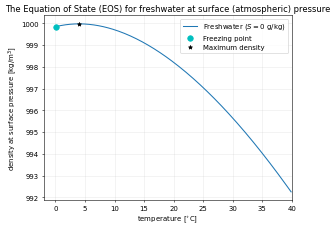

In [9]:
rho_fresh.plot(
    label="Freshwater ($S=0$ g/kg)"
)
plt.plot(
    t_freezing_fresh,
    rho_fresh.sel(TEMP_bin=t_freezing_fresh, method="nearest"),
    "co", markersize=8,
    label = "Freezing point"
)

plt.xlim(-2, 40)
plt.plot(
    rho_fresh.idxmax(),
    rho_fresh.max(),
    "k*",
    label="Maximum density"
)
plt.legend()

# density of ice is 917 kg/m^3
plt.grid(True, alpha=0.25)
plt.ylabel(r"density at surface pressure [kg/m$^{3}$]")
plt.xlabel(r"temperature [$^{\circ}$C]")
plt.title("The Equation of State (EOS) for freshwater at surface (atmospheric) pressure");
plt.savefig("../figures/Lecture06_EOS_freshwater_surface.png", bbox_inches="tight", dpi=200)

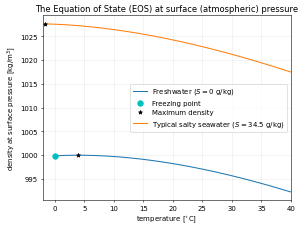

In [10]:
rho_fresh.plot(
    label="Freshwater ($S=0$ g/kg)"
)
plt.plot(
    t_freezing_fresh,
    rho_fresh.sel(TEMP_bin=t_freezing_fresh, method="nearest"),
    "co", markersize=8,
    label = "Freezing point"
)

plt.xlim(-2, 40)
plt.plot(
    rho_fresh.idxmax(),
    rho_fresh.max(),
    "k*",
    label="Maximum density"
)
plt.legend()

rho_salty.plot(
    label="Typical salty seawater ($S=34.5$ g/kg)"
)
plt.plot(
    t_freezing_salty,
    rho_salty.sel(TEMP_bin=t_freezing_salty, method="nearest"),
    "co", markersize=8,
)

plt.xlim(-2, 40)
plt.plot(
    rho_salty.idxmax(),
    rho_salty.max(),
    "k*",
)
plt.legend()

plt.legend()
plt.grid(True, alpha=0.25)
plt.ylabel("density at surface pressure [kg/m$^{3}$]")
plt.xlabel(r"temperature [$^{\circ}$C]")
plt.title("The Equation of State (EOS) at surface (atmospheric) pressure");

plt.savefig("../figures/Lecture06_EOS_saltwater_surface.png", bbox_inches="tight", dpi=200)

/Users/henrifdrake/anaconda3/envs/ESS130/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in t_freezing
  result_data = func(*input_data)


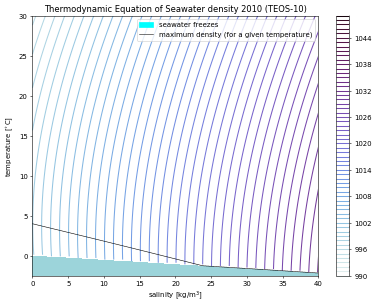

In [11]:
fig = plt.figure(figsize=(8,6.25))

frozen = TS_hist.TEMP_bin <= gsw.t_freezing(TS_hist.SALINITY_bin, 0., 0)
plt.fill_between([], [], [], color="cyan", label = "seawater freezes")
ct = TS_hist["rho"].where(~frozen).plot.contour(y="TEMP_bin", levels=np.arange(990., 1050, 1.), cmap=cmocean.cm.dense)
plt.clabel(ct, ct.levels[::2],inline=True)
plt.colorbar(ct)

frozen_hires = TS_hist_hires.TEMP_bin <= gsw.t_freezing(TS_hist_hires.SALINITY_bin, 0., 0)
pc = frozen_hires.where(frozen_hires).plot(y="TEMP_bin", cmap=cmocean.cm.ice, vmin=0.5, vmax=1.1, add_colorbar=False)
pc = TS_hist_hires["rho"].where(~frozen_hires).idxmax("TEMP_bin").plot(x="SALINITY_bin", color="k", label="maximum density (for a given temperature)", lw=0.75)
plt.legend()

plt.ylabel(r"temperature [$^{\circ}$C]")
plt.xlabel(r"salinity [kg/m$^{3}$]")
plt.title(r"Thermodynamic Equation of Seawater density 2010 (TEOS-10)")
plt.tight_layout()
plt.xlim(0, 40)
plt.ylim(-2.5, 30)
plt.savefig("../figures/Lecture06_EOS_seawater_density_TS.png", bbox_inches="tight", dpi=200)

/Users/henrifdrake/anaconda3/envs/ESS130/lib/python3.12/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in t_freezing
  result_data = func(*input_data)


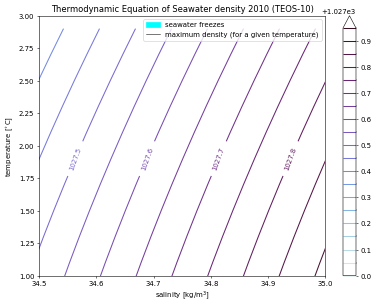

In [12]:
fig = plt.figure(figsize=(8,6.25))

frozen = TS_hist.TEMP_bin <= gsw.t_freezing(TS_hist.SALINITY_bin, 0., 0)
plt.fill_between([], [], [], color="cyan", label = "seawater freezes")
ct = TS_hist["rho"].where(~frozen).sel(TEMP_bin=slice(0.9, 3.1), SALINITY_bin=slice(34.4, 35.1)).plot.contour(y="TEMP_bin", levels=np.arange(1027., 1028, 0.05), cmap=cmocean.cm.dense)
plt.clabel(ct, ct.levels[::2],inline=True)
plt.colorbar(ct)

frozen_hires = TS_hist_hires.TEMP_bin <= gsw.t_freezing(TS_hist_hires.SALINITY_bin, 0., 0)
pc = frozen_hires.where(frozen_hires).plot(y="TEMP_bin", cmap=cmocean.cm.ice, vmin=0.5, vmax=1.1, add_colorbar=False)
pc = TS_hist_hires["rho"].where(~frozen_hires).idxmax("TEMP_bin").plot(x="SALINITY_bin", color="k", label="maximum density (for a given temperature)", lw=0.75)
plt.legend()

plt.ylabel(r"temperature [$^{\circ}$C]")
plt.xlabel(r"salinity [kg/m$^{3}$]")
plt.title(r"Thermodynamic Equation of Seawater density 2010 (TEOS-10)")
plt.tight_layout()
plt.xlim(34.5, 35)
plt.ylim(1, 3)
plt.savefig("../figures/Lecture06_EOS_seawater_density_TS_zoom.png", bbox_inches="tight", dpi=200)

In [13]:
gsw.alpha_wrt_t_exact(34.5, 1., 0), gsw.beta_const_t_exact(34.5, 1., 0)

(6.397008568119086e-05, 0.0007784617234695267)

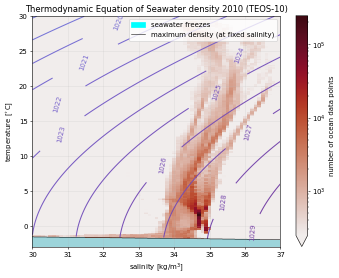

In [14]:
import matplotlib.colors as colors
lognormrange = 1e-3
fig = plt.figure(figsize=(8,6))
pc = TS_hist.where(TS_hist!=0, TS_hist.max()*lognormrange).plot(
    x="SALINITY_bin",
    y="TEMP_bin",
    norm=colors.LogNorm(vmin=TS_hist.max()*lognormrange, vmax=TS_hist.max()),
    cmap=cmocean.cm.amp
)
ct = TS_hist["rho"].where(~frozen).sel(TEMP_bin=slice(-3, 30), SALINITY_bin=slice(30, 37)).plot.contour(y="TEMP_bin", levels=np.arange(990., 1050, 1.), cmap=cmocean.cm.dense)
plt.clabel(ct, ct.levels[::1],inline=True)
pc.colorbar.set_label("number of ocean data points")
plt.fill_between([], [], [], color="cyan", label = "seawater freezes")
pc = frozen_hires.where(frozen_hires).plot(y="TEMP_bin", cmap=cmocean.cm.ice, vmin=0.5, vmax=1.1, add_colorbar=False)
TS_hist_hires["rho"].where(~frozen_hires).idxmax("TEMP_bin").plot(x="SALINITY_bin", color="k", label="maximum density (at fixed salinity)", lw=0.75)
plt.legend()
plt.title(r"Thermodynamic Equation of Seawater density 2010 (TEOS-10)")
plt.ylabel(r"temperature [$^{\circ}$C]")
plt.xlabel(r"salinity [kg/m$^{3}$]")
plt.grid(True, alpha=0.25)
plt.xlim(30, 37)
plt.ylim(-3, 30)
fig.savefig("../figures/Lecture06_EOS_TS_histogram_WOCE.png", bbox_inches="tight", dpi=300)

In [15]:
seafloor = xr.open_dataset("../data/raw_observational_products/SYNBATH_V2.0.nc").z[::60, ::60].compute()

In [16]:
p = gsw.p_from_z(-ds_woce.ZAX, ds_woce.LAT)
SA = gsw.SA_from_SP(ds_woce.SALINITY, p, ds_woce.LON, ds_woce.LAT)
PT = gsw.pt_from_t(SA, ds_woce.TEMP, p, 0.)
CT = gsw.CT_from_t(SA, ds_woce.TEMP, p)
ρ = gsw.rho(SA, CT, p)
σ2 = gsw.sigma2(SA, CT)

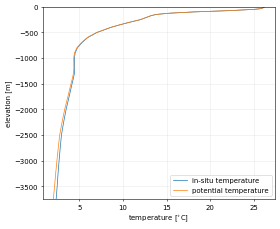

In [17]:
fig = plt.figure(figsize=(6,5))
plt.plot(
    ds_woce.TEMP.sel(LON=360-27.5, LAT=0, method="nearest"),
    -ds_woce.ZAX,
    label="in-situ temperature",
    lw=1,
)
plt.plot(
    PT.sel(LON=360-27.5, LAT=0, method="nearest"),
    -ds_woce.ZAX,
    label="potential temperature",
    lw=1,
)
plt.legend()

plt.ylim(-3750, 0)
plt.xlabel(r"temperature [$^{\circ}$C]")
plt.ylabel("elevation [m]")
plt.grid(True, alpha=0.25)
fig.savefig("../figures/Lecture06_potential_temperature.png", bbox_inches="tight", dpi=300)

(5000.0, 0.0)

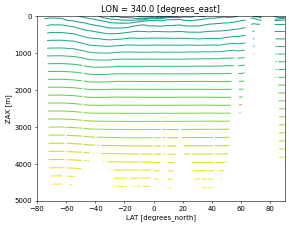

In [18]:
ρ.sel(LON=340, method="nearest").plot.contour(y="ZAX", levels=np.arange(1000, 1050, 1.))
plt.ylim(5000, 0)

(5000.0, 0.0)

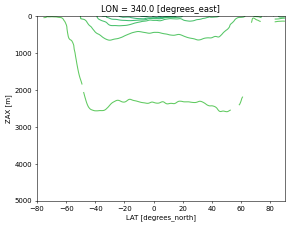

In [19]:
σ2.sel(LON=340, method="nearest").plot.contour(y="ZAX", levels=np.arange(0, 50, 1.))
plt.ylim(5000, 0)